# Conditional Expectation Regression with NCP (1D -> 1D)

This notebook trains a small Neural Conditional Probability (NCP) model on a 1D->1D toy dataset where the conditional distribution is:
- Unimodal and noisy for |x| <= 1 (expectation is meaningful and near the mode).
- Bimodal for 1 < |x| <= 2 (two symmetric modes; expectation is close to the middle with low probability).

We evaluate how well NCP learns a representation that supports accurate conditional expectation regression.

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from symm_learning.models import MLP
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from symm_rep_learn.models.neural_conditional_probability.ncp import NCP

sys.path.append(os.getcwd())
from plotting import (
    LiveLossPlotter,
    dataframe_to_markdown,
    log_condexp_summary_metrics,
    plot_condexp_metrics_panels,
    plot_conditional_cdf_on_support,
    plot_expectations_with_quantiles,
    plot_sample_efficiency,
    scatter_with_density,
)

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
plt.style.use("seaborn-v0_8-notebook")
FIG_SIZE = (4, 3)

# Paths
ROOT = pathlib.Path(os.getcwd())
PLOT_PATH = ROOT / "plots"
PLOT_PATH.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH = ROOT / "checkpoints"
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

print(f"Using device: {DEVICE}")
print(f"Checkpoint directory: {CHECKPOINT_PATH}")

EMBEDDING_DIM = 32
BATCH_SIZE = 2024
N = 20000  # Number of training samples.

Using device: cuda
Checkpoint directory: /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints


In [2]:
# Checkpoint utility functions
def save_checkpoint(model, optimizer, best_val_loss, epoch, checkpoint_path):
    """Save model checkpoint"""
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "best_val_loss": best_val_loss,
        "epoch": epoch,
        "seed": SEED,
        "embedding_dim": EMBEDDING_DIM,
        "batch_size": BATCH_SIZE,
    }
    torch.save(checkpoint, checkpoint_path)
    # print(f"Checkpoint saved to {checkpoint_path}")


def load_checkpoint(model, optimizer, checkpoint_path):
    """Load model checkpoint if it exists"""
    if checkpoint_path.exists():
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint["model_state_dict"])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        return checkpoint["best_val_loss"], checkpoint["epoch"]
    return None, None


def checkpoint_exists(checkpoint_path):
    """Check if checkpoint exists"""
    return checkpoint_path.exists()


# Checkpoint management utilities
def list_checkpoints():
    """List all available checkpoints"""
    checkpoints = list(CHECKPOINT_PATH.glob("*.pth"))
    if checkpoints:
        print("Available checkpoints:")
        for ckpt in checkpoints:
            size = ckpt.stat().st_size / (1024 * 1024)  # MB
            print(f"  - {ckpt.name} ({size:.1f} MB)")
    else:
        print("No checkpoints found")
    return checkpoints


# Show current checkpoint status
print("Current checkpoint status:")
list_checkpoints()

Current checkpoint status:
Available checkpoints:
  - baseline_mlp_N=20000_seed=42.pth (0.1 MB)
  - ncp_model_N=1000_seed=42.pth (0.2 MB)
  - ncp_model_N=7000_seed=42.pth (0.2 MB)
  - baseline_mlp_N=10000_seed=42.pth (0.1 MB)
  - ncp_model_N=20000_seed=42.pth (0.2 MB)
  - baseline_mlp_N=1000_seed=42.pth (0.1 MB)
  - encp_model_N=10000_seed=42.pth (4.4 MB)
  - encp_model_N=1000_seed=42.pth (4.4 MB)
  - baseline_mlp_N=7000_seed=42.pth (0.1 MB)
  - ncp_model_N=10000_seed=42.pth (0.2 MB)
  - baseline_mlp_N=5000_seed=42.pth (0.1 MB)
  - ncp_model_N=5000_seed=42.pth (0.2 MB)
  - encp_model_N=20000_seed=42.pth (4.4 MB)
  - encp_model_N=7000_seed=42.pth (4.4 MB)
  - encp_model_N=5000_seed=42.pth (4.4 MB)


[PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/baseline_mlp_N=20000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/ncp_model_N=1000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/ncp_model_N=7000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/baseline_mlp_N=10000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/ncp_model_N=20000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/baseline_mlp_N=1000_seed=42.pth'),
 PosixPath('/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/encp_model_N=10000_

## Synthetic dataset: three noise zones with reflection invariance
Let $f_c(x)$ denote the smooth carrier function defined above. The conditional distribution of $Y$ given $X=x$ is:

- $|x| \le 1$: $Y = f_c(x) + 



arepsilon_{\exp}$ with $



arepsilon_{\exp} \sim \mathrm{Exp}(	ext{scale}=s(|x|))$, where $s(|x|)=0.1 + 0.1\cos^{2}(2|x|)$ (the mean equals the scale).
- $1 < |x| \le 2$: $Y = f_c(x) + \sigma_{	ext{sym}}(|x|) Z$, where $Z \sim \mathcal N(0,1)$ and $\sigma_{	ext{sym}}(|x|)=0.04 + 0.05\cos^{2}(6|x|) + 0.15\sin^{2}(9|x|)$.
- $|x| > 2$: $Y = S\,a(|x|) + \sigma_{	ext{bi}}(|x|) Z'$, with $S \in \{-1,1\}$ equiprobable, $Z' \sim \mathcal N(0,1)$, $a(|x|)=0.6(|x|-2)_{+}$, and $\sigma_{	ext{bi}}(|x|)=0.03 + 0.10\cos^{2}(5|x|) + 0.06\cos^{2}(4|x|)$.

The resulting joint distribution $(X,Y)$ is invariant to the reflection $(x,y) \mapsto (-x,-y)$ despite the heterogeneous noise structure.

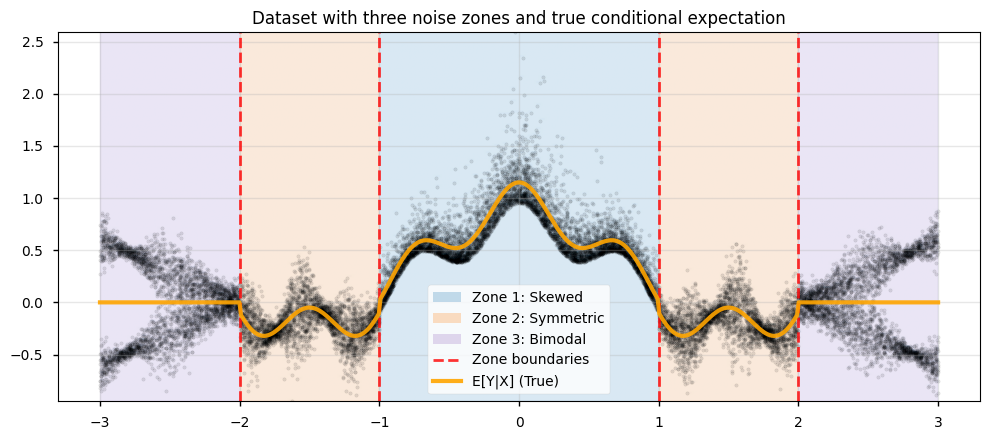

In [3]:
def f_center(x):
    return 0.5 * torch.cos(2 / 3 * math.pi * x) + 0.2 * torch.cos(4 * 2 / 3 * math.pi * x) + 0.25


def exponential_scale_param(absx):
    """Exponential noise scale parameter as a function of |x|."""
    return 0.1 + 0.1 * (torch.cos(absx * 2) ** 2)


def make_dataset(n=20000, seed=SEED, x=None):
    """Generate dataset (x, y) with three noise zones.

    Args:
        n: number of samples to generate (ignored if x is an array with its own length)
        seed: RNG seed
        x: None (default, sample x ~ U[-3,3]); scalar (use a constant x for all samples);
           or array-like of shape (n,) or (n,1) providing the x's to use.
    """
    rng = np.random.default_rng(seed)

    if x is None:
        x_np = rng.uniform(-3.0, 3.0, size=(n, 1)).astype(np.float32)
    else:
        if np.isscalar(x):
            x_np = np.full((n, 1), float(x), dtype=np.float32)
        else:
            x_arr = np.asarray(x, dtype=np.float32)
            if x_arr.ndim == 1:
                x_arr = x_arr.reshape(-1, 1)
            assert x_arr.shape[1] == 1, f"x must be (n,) or (n,1), got {x_arr.shape}"
            if x_arr.shape[0] != n:
                n = x_arr.shape[0]
            x_np = x_arr

    x_t = torch.from_numpy(x_np)
    absx = torch.abs(x_t)
    # Zone-specific noise parameters
    sigma_sym = 0.04 + 0.05 * np.cos(6 * absx) ** 2 + 0.15 * torch.sin(9 * absx) ** 2
    sigma_bi = 0.03 + 0.1 * (np.cos(5 * absx)) ** 2 + 0.06 * np.cos(4 * absx) ** 2
    base_noise = torch.randn_like(x_t)
    scale_param = exponential_scale_param(absx)  # scale parameter for exponential noise
    u = torch.from_numpy(rng.uniform(0, 1, size=x_t.shape)).to(torch.float32)
    eps_exp = -scale_param * torch.log(u)
    eps_sym = base_noise * sigma_sym
    s = torch.from_numpy(rng.choice([-1.0, 1.0], size=(n, 1))).to(torch.float32)
    a = 0.6 * (absx - 2.0).clamp(min=0)
    eps_bi = torch.randn_like(x_t) * sigma_bi
    y_zone1 = f_center(x_t) + eps_exp
    y_zone2 = f_center(x_t) + eps_sym
    y_zone3 = s * a + eps_bi
    y = torch.where(absx <= 1.0, y_zone1, torch.where(absx <= 2.0, y_zone2, y_zone3))
    return x_t, y


@torch.no_grad()
def true_condexp(x):
    """Compute true conditional expectation accounting for noise distributions."""
    x = torch.as_tensor(x, dtype=torch.float32)
    absx = torch.abs(x)
    scale_param = exponential_scale_param(absx)
    expected_exp_noise = scale_param
    zone1_exp = f_center(x) + expected_exp_noise
    zone2_exp = f_center(x)
    zone3_exp = torch.zeros_like(x)
    y = torch.where(absx <= 1.0, zone1_exp, torch.where(absx <= 2.0, zone2_exp, zone3_exp))
    return y


# Generate full dataset
x, y = make_dataset(N)

# Comprehensive plot with data, zone boundaries, and expected values
fig, ax = plt.subplots(figsize=(FIG_SIZE[0] * 2.5, FIG_SIZE[1] * 1.5))

scatter_with_density(x.numpy(), y.numpy(), ax=ax)

# Highlight noise zones with translucent spans and annotate them
from matplotlib.patches import Patch

zone_styles = {
    "Zone 1": {"intervals": [(-1, 1)], "color": "tab:blue", "label": "Zone 1: Skewed"},
    "Zone 2": {"intervals": [(-2, -1), (1, 2)], "color": "tab:orange", "label": "Zone 2: Symmetric"},
    "Zone 3": {"intervals": [(-3, -2), (2, 3)], "color": "tab:purple", "label": "Zone 3: Bimodal"},
}
for cfg in zone_styles.values():
    for xmin, xmax in cfg["intervals"]:
        ax.axvspan(xmin, xmax, color=cfg["color"], alpha=0.15, zorder=0)

# Zone boundaries
for j, boundary in enumerate((-2, -1, 1, 2)):
    ax.axvline(
        boundary, color="red", linestyle="--", alpha=0.8, linewidth=2, label="Zone boundaries" if j == 0 else None
    )

# Plot expected values
x_grid = torch.linspace(-3.0, 3.0, 500).reshape(-1, 1)
y_expected = true_condexp(x_grid)
ax.plot(x_grid.numpy(), y_expected.numpy(), "orange", linewidth=3, label="E[Y|X] (True)", alpha=0.9)

# Text labels inside zones
ymin, ymax = ax.get_ylim()
y_text = ymax - 0.05 * (ymax - ymin)

ax.set_title("Dataset with three noise zones and true conditional expectation")

# Combine legend entries
handles, labels = ax.get_legend_handles_labels()
zone_patches = [Patch(facecolor=cfg["color"], alpha=0.25, label=cfg["label"]) for cfg in zone_styles.values()]
handles = zone_patches + handles
labels = [patch.get_label() for patch in zone_patches] + labels
ax.legend(handles, labels)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOT_PATH / "data_with_zones_and_true_expectation.png", dpi=300)
plt.show()

In [4]:
# Dataset statistics and reflection invariance check
mask_z1 = (torch.abs(x) <= 1.0).squeeze()
mask_z2 = ((torch.abs(x) > 1.0) & (torch.abs(x) <= 2.0)).squeeze()
mask_z3 = (torch.abs(x) > 2.0).squeeze()

print("Dataset Zone Statistics:")
print(f"Zone 1 (|x| ≤ 1): {mask_z1.sum()} samples ({mask_z1.sum() / len(x) * 100:.1f}%)")
print(f"Zone 2 (1 < |x| ≤ 2): {mask_z2.sum()} samples ({mask_z2.sum() / len(x) * 100:.1f}%)")
print(f"Zone 3 (|x| > 2): {mask_z3.sum()} samples ({mask_z3.sum() / len(x) * 100:.1f}%)")

# Show reflection invariance by checking y-values at symmetric x points
x_test_vals = [0.5, 1.5, 2.5]
print("\nReflection Invariance Check:")
for x_val in x_test_vals:
    # Generate samples at +x and -x
    _, y_pos = make_dataset(n=2000, seed=SEED + 1, x=x_val)
    _, y_neg = make_dataset(n=2000, seed=SEED + 1, x=-x_val)
    y_pos_mean = y_pos.mean().item()
    y_neg_mean = y_neg.mean().item()
    y_pos_std = y_pos.std().item()
    y_neg_std = y_neg.std().item()
    # Check true expected values
    true_exp_pos = true_condexp(torch.tensor([[x_val]])).item()
    true_exp_neg = true_condexp(torch.tensor([[-x_val]])).item()

Dataset Zone Statistics:
Zone 1 (|x| ≤ 1): 6627 samples (33.1%)
Zone 2 (1 < |x| ≤ 2): 6722 samples (33.6%)
Zone 3 (|x| > 2): 6651 samples (33.3%)

Reflection Invariance Check:


## Split, standardize, and create DataLoaders

In [5]:
# Train/val/test split
idx = torch.randperm(x.shape[0])
train_end = int(0.7 * len(idx))
val_end = int(0.85 * len(idx))
idx_tr, idx_val, idx_te = idx[:train_end], idx[train_end:val_end], idx[val_end:]

x_tr, y_tr = x[idx_tr], y[idx_tr]
x_val, y_val = x[idx_val], y[idx_val]
x_te, y_te = x[idx_te], y[idx_te]

# Standardize using train stats
x_mean, x_std = x_tr.mean(0, keepdim=True), x_tr.std(0, keepdim=True) + 1e-8
y_mean, y_std = y_tr.mean(0, keepdim=True), y_tr.std(0, keepdim=True) + 1e-8

x_tr_c = (x_tr - x_mean) / x_std
y_tr_c = (y_tr - y_mean) / y_std
x_val_c = (x_val - x_mean) / x_std
y_val_c = (y_val - y_mean) / y_std
x_te_c = (x_te - x_mean) / x_std
y_te_c = (y_te - y_mean) / y_std

train_dl = DataLoader(TensorDataset(x_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(TensorDataset(x_val_c, y_val_c), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(TensorDataset(x_te_c, y_te_c), batch_size=BATCH_SIZE, shuffle=False)

print("Standardization done.")

Standardization done.


## Baseline: MLP trained with MSE (same architecture and training config)

In [6]:
baseline_mlp = MLP(
    in_dim=1,
    out_dim=1,
    hidden_units=[EMBEDDING_DIM * 2] * 2 + [EMBEDDING_DIM] * 2,
    activation=torch.nn.ELU(),
    bias=True,
).to(DEVICE)
print(baseline_mlp)
opt_base = torch.optim.Adam(baseline_mlp.parameters(), lr=1e-3)

# Match training hyperparams between baseline and NCP
EPOCHS = 1000
CHECK_EVERY = 10
PATIENCE = 10
PLOT_FREQ = 100  # update live plot every N epochs

# Checkpoint path for baseline
baseline_checkpoint = CHECKPOINT_PATH / f"baseline_mlp_N={N:d}_seed={SEED:d}.pth"


@torch.no_grad()
def val_mse(model, dl):
    model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = model(xb)
        tot += torch.mean((pred - yb) ** 2).item()
        n += 1
    return tot / max(1, n)


# Check if checkpoint exists
if checkpoint_exists(baseline_checkpoint):
    print("Loading baseline model from checkpoint...")
    best_val, last_epoch = load_checkpoint(baseline_mlp, opt_base, baseline_checkpoint)
    print(f"Baseline loaded - best val MSE: {best_val:.5f}")
else:
    print("Training baseline model from scratch...")
    best_val = float("inf")
    pat = 0
    best_baseline_state = baseline_mlp.state_dict()

    pbar = tqdm(range(EPOCHS), desc="Training Baseline MLP")
    plotter_base = LiveLossPlotter(title="Baseline: train/val loss (MSE)", plot_freq=PLOT_FREQ)
    for epoch in pbar:
        baseline_mlp.train()
        for xb, yb in train_dl:  # same BATCH_SIZE as defined earlier
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt_base.zero_grad()
            pred = baseline_mlp(xb)
            loss = torch.mean((pred - yb) ** 2)
            loss.backward()
            opt_base.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm = val_mse(baseline_mlp, val_dl)
            pbar.set_postfix(train_loss=loss.item(), val_mse=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_base.update(epoch, train_loss=float(loss.item()), val_loss=float(vm), force=True)
            if vm < best_val:
                best_val = vm
                best_baseline_state = {k: v.cpu() for k, v in baseline_mlp.state_dict().items()}
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(baseline_mlp, opt_base, best_val, epoch, baseline_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping baseline at epoch {epoch}")
                    break

    baseline_mlp.load_state_dict(best_baseline_state)
    plotter_base.close()
    print(f"Baseline best val MSE: {best_val:.5f}")


@torch.no_grad()
def baseline_predict(x_in):
    baseline_mlp.eval()
    return baseline_mlp(x_in.to(DEVICE)).cpu()


# Baseline-only conditional expectation plot (standardized space)
x_grid = torch.linspace(-2.0, 2.0, 600).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)

# Use the plotting utility to render expectations (no quantiles here)
expectations_baseline = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "Baseline E[Y|X]": y_base_c.numpy().ravel(),
}

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
Loading baseline model from checkpoint...
Loading checkpoint from /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/checkpoints/baseline_mlp_N=20000_seed=42.pth
Baseline loaded - best val MSE: 0.30042


## NCP model (after baseline)

In [7]:
from symm_rep_learn.nn.layers import ResidualEncoder

BATCH_NORM = False
ORTH_REG = 0.01
CENTERING_REG = 0.00
MOMENTUM = 0.999
ncp = NCP(
    embedding_x=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_y=ResidualEncoder(
        MLP(
            in_dim=1,
            out_dim=EMBEDDING_DIM,
            hidden_units=[EMBEDDING_DIM * 2] * 2,
            activation=torch.nn.ELU(),
            bias=True,
            batch_norm=BATCH_NORM,
        ),
        in_dim=1,
    ),
    embedding_dim_x=EMBEDDING_DIM + 1,
    embedding_dim_y=EMBEDDING_DIM + 1,
    orth_reg=ORTH_REG,
    centering_reg=CENTERING_REG,
    momentum=MOMENTUM,
).to(DEVICE)

print(ncp)

# Train NCP with early stopping on validation negative loss (the lower, the better)
CHECK_EVERY = 10
PATIENCE = 50
NCP_LR = 2e-3
optimizer = torch.optim.Adam(ncp.parameters(), lr=NCP_LR)

# Checkpoint path for NCP
ncp_checkpoint = CHECKPOINT_PATH / f"ncp_model_N={N:d}_seed={SEED:d}.pth"


@torch.no_grad()
def val_objective(ncp_model, dl):
    metrics = {}
    ncp_model.eval()
    tot, n = 0.0, 0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        fx, hy = ncp_model(xb, yb)
        loss, batch_metrics = ncp_model.loss(fx, hy)
        tot += float(loss.item())
        n += 1

        # Update metrics with batch values
        for k, v in batch_metrics.items():
            if k in metrics:
                metrics[k].append(v)
            else:
                metrics[k] = [v]
    # Average the metrics across the batch
    for k, v in metrics.items():
        metrics[k] = np.mean(v)

    return tot / max(1, n), metrics


# Check if checkpoint exists
if checkpoint_exists(ncp_checkpoint):
    print("Loading NCP model from checkpoint...")
    best_val, last_epoch = load_checkpoint(ncp, optimizer, ncp_checkpoint)
    print(f"NCP loaded - best val objective: {best_val:.5f}")
else:
    print("Training NCP model from scratch...")
    best_val = float("inf")
    pat = 0
    best_ncp_state = ncp.state_dict()

    pbar = tqdm(range(3 * EPOCHS), desc="Training NCP")
    VAL_METRIC = "||k(x,y) - k_r(x,y)||"
    plotter_ncp = LiveLossPlotter(title=f"NCP: train/val {VAL_METRIC}", plot_freq=PLOT_FREQ)
    for epoch in pbar:
        ncp.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            fx, hy = ncp(xb, yb)
            loss, metrics = ncp.loss(fx, hy)
            loss.backward()
            optimizer.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm, val_metrics = val_objective(ncp, val_dl)
            pbar.set_postfix(loss=float(loss.item()), val=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_ncp.update(epoch, train_loss=float(metrics[VAL_METRIC]), val_loss=float(val_metrics[VAL_METRIC]))
            if vm < best_val:
                best_val = vm
                best_ncp_state = {k: v.cpu() for k, v in ncp.state_dict().items()}
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(ncp, optimizer, best_val, epoch, ncp_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping NCP at epoch {epoch}")
                    break

    ncp.load_state_dict(best_ncp_state)
    ncp.eval()
    plotter_ncp.close()
    print(f"NCP best val objective: {best_val:.5f}")

ncp.eval()

NCP(
  (_embedding_x): ResidualEncoder(
    (encoder): MLP(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (_embedding_y): ResidualEncoder(
    (encoder): MLP(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (Dr): ParametrizedLinear(
    in_features=33, out_features=33, bias=False
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
      )
    )
  )
  (ema_stats): EMAStats(num_features_x=33, num_features_y=33, momentum=0.999, eps=1e-06, center_with_running_

NCP(
  (_embedding_x): ResidualEncoder(
    (encoder): MLP(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (_embedding_y): ResidualEncoder(
    (encoder): MLP(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=64, out_features=32, bias=True)
      )
    )
  )
  (Dr): ParametrizedLinear(
    in_features=33, out_features=33, bias=False
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _SpectralNorm()
      )
    )
  )
  (ema_stats): EMAStats(num_features_x=33, num_features_y=33, momentum=0.999, eps=1e-06, center_with_running_

# eNCP


In [8]:
import escnn
from symm_learning.models import IMLP

from symm_rep_learn.models import ENCP

G = escnn.group.CyclicGroup(2)
trivial_irrep = G.trivial_representation
reflection_irrep = G.irrep(1)
gspace = escnn.gspaces.no_base_space(G)

x_type = escnn.nn.FieldType(gspace, [reflection_irrep])
y_type = escnn.nn.FieldType(gspace, [trivial_irrep])

encp = ENCP(
    embedding_x=IMLP(
        in_type=x_type,
        out_dim=EMBEDDING_DIM,
        hidden_units=[EMBEDDING_DIM * 2] * 2,
        activation="ELU",
        bias=True,
    ),
    embedding_y=IMLP(
        in_type=y_type,
        out_dim=EMBEDDING_DIM,
        hidden_units=[EMBEDDING_DIM * 2] * 2,
        activation="ELU",
        bias=True,
    ),
    orth_reg=ORTH_REG,
    centering_reg=CENTERING_REG,
    momentum=MOMENTUM,
).to(DEVICE)
print(encp)

# Checkpoint path for eNCP
encp_checkpoint = CHECKPOINT_PATH / f"encp_model_N={N:d}_seed={SEED:d}.pth"

# Check if checkpoint exists
if checkpoint_exists(encp_checkpoint):
    encp_optimizer = torch.optim.Adam(encp.parameters(), lr=NCP_LR / 2)
    best_val, last_epoch = load_checkpoint(encp, encp_optimizer, encp_checkpoint)
    best_encp_state = encp.state_dict()
    print(f"eNCP loaded - best val objective: {best_val:.5f}")
else:
    print("Training eNCP model from scratch...")
    best_val = float("inf")
    pat = 0
    best_encp_state = encp.state_dict()

    pbar = tqdm(range(2 * EPOCHS), desc="Training eNCP")
    plotter_encp = LiveLossPlotter(title=f"eNCP: train/val {VAL_METRIC}", plot_freq=PLOT_FREQ)

    encp_optimizer = torch.optim.Adam(encp.parameters(), lr=NCP_LR / 2)

    for epoch in pbar:
        encp.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            encp_optimizer.zero_grad()
            fx, hy = encp(xb, yb)
            loss, metrics = encp.loss(fx, hy)
            loss.backward()
            encp_optimizer.step()

        if epoch % CHECK_EVERY == 0 or epoch == EPOCHS - 1:
            vm, val_metrics = val_objective(encp, val_dl)
            pbar.set_postfix(loss=float(loss.item()), val=vm)
            # live update at val check (forces redraw regardless of freq)
            plotter_encp.update(epoch, train_loss=float(metrics[VAL_METRIC]), val_loss=float(val_metrics[VAL_METRIC]))
            if vm < best_val:
                best_val = vm
                best_encp_state = encp.state_dict()
                pat = 0
                # Save checkpoint when we get a better validation score
                save_checkpoint(encp, encp_optimizer, best_val, epoch, encp_checkpoint)
            else:
                pat += 1
                if pat >= PATIENCE:
                    print(f"Early stopping eNCP at epoch {epoch}")
                    break

    plotter_encp.close()
    print(f"eNCP best val objective: {best_val:.5f}")

encp.eval()
print("eNCP model ready for inference")

ENCP(
  (_embedding_x): SequentialModule(
    (0): IMLP(
      (equiv_feature_extractor): EMLP(
        C2-equivariant MLP: in=[C2: {irrep_1 (x1)}(1)], out=[C2: {regular (x32)}(64)]
        (net): SequentialModule(
          (0): Linear(
            (_basisexpansion): BlocksBasisExpansion(
              (block_expansion_('irrep_1', 'regular')): SingleBlockBasisExpansion()
            )
          )
          (1): ELU(alpha=1.0, inplace=False, type=[C2: {regular (x32)}(64)])
          (2): Linear(
            (_basisexpansion): BlocksBasisExpansion(
              (block_expansion_('regular', 'regular')): SingleBlockBasisExpansion()
            )
          )
          (3): ELU(alpha=1.0, inplace=False, type=[C2: {regular (x32)}(64)])
          (4): Linear(
            (_basisexpansion): BlocksBasisExpansion(
              (block_expansion_('regular', 'regular')): SingleBlockBasisExpansion()
            )
          )
        )
      )
      (inv_feature_extractor): IrrepSubspaceNormPooling

## CCDF comparison at unimodal and bimodal x
We compare the predicted conditional CDF (NCP) against a numerically estimated ground truth CCDF (by sampling from the known generative process) and the marginal CDF, for two conditioning values: one in the unimodal region and one in the bimodal region.

## Visualize conditional expectation vs ground truth

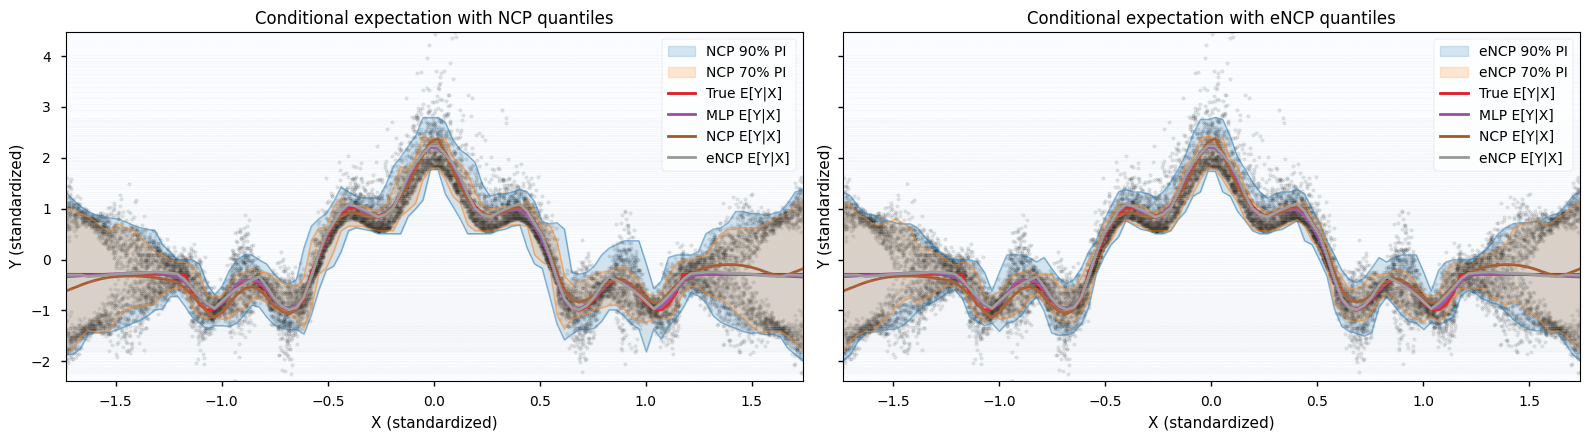

In [9]:
SEED = 42
ncp.eval()
encp.eval()
encp.load_state_dict(best_encp_state)

# Set seed
torch.manual_seed(SEED)
np.random.seed(SEED)
RIDGE_REG = 1e-2
# Fit the built-in linear decoder to map h(y) -> y (standardized)
dec_dl = DataLoader(TensorDataset(y_tr_c, y_tr_c), batch_size=BATCH_SIZE, shuffle=False)
ncp_lin_decoder = ncp.fit_linear_decoder(train_dataloader=dec_dl, ridge_reg=RIDGE_REG, lstsq=False)
encp_lin_decoder = encp.fit_linear_decoder(train_dataloader=dec_dl, ridge_reg=RIDGE_REG, lstsq=False)

# Build NCP Conditional CDF helper and 90% quantiles for y (support is in standardized y-space)

from symm_rep_learn.inference import ENCPConditionalCDF, NCPConditionalCDF

discretization_kwargs = dict(random_state=int(SEED), subsample=None, u_eps=1e-5, output_distribution="normal")
ncp_ccdf = NCPConditionalCDF(
    model=ncp,
    y_train=y_tr_c,
    support_discretization_points=200,
    ridge_reg=RIDGE_REG,
    support_strategy="quantile_transformer",
    discretizer_kwargs=discretization_kwargs,
)
encp_ccdf = ENCPConditionalCDF(
    model=encp,
    y_train=y_type(y_tr_c),
    support_discretization_points=200,
    ridge_reg=RIDGE_REG,
    support_strategy="quantile_transformer",
    discretizer_kwargs=discretization_kwargs,
)

# Build dense grid on standardized x (do NOT use y support for x)
x_grid = torch.linspace(x_tr.min().item(), x_tr.max().item(), 100).reshape(-1, 1)
x_grid_c = (x_grid - x_mean) / x_std

with torch.no_grad():
    y_true_c = (true_condexp(x_grid) - y_mean) / y_std
    y_base_c = baseline_predict(x_grid_c)
    y_pred_ncp_c = ncp.conditional_expectation(x=x_grid_c.to(DEVICE), hy2zy=ncp_lin_decoder).cpu()
    y_pred_encp_c = encp.conditional_expectation(x=x_grid_c.to(DEVICE), hy2zy=encp_lin_decoder).cpu()

ncp_quantiles, encp_quantiles = {}, {}
for alpha in [0.10, 0.3]:
    q_lo_ncp, q_up_ncp = ncp_ccdf.conditional_quantiles(x_cond=x_grid_c, alpha=alpha)
    ncp_quantiles[alpha] = (q_lo_ncp, q_up_ncp)
    q_lo_encp, q_up_encp = encp_ccdf.conditional_quantiles(x_cond=x_grid_c, alpha=alpha)
    encp_quantiles[alpha] = (q_lo_encp, q_up_encp)

# Prepare inputs for the helper
expectations = {
    "True E[Y|X]": y_true_c.numpy().ravel(),
    "MLP E[Y|X]": y_base_c.numpy().ravel(),
    "NCP E[Y|X]": y_pred_ncp_c.numpy().ravel(),
    "eNCP E[Y|X]": y_pred_encp_c.numpy().ravel(),
}

est_quantiles_ncp = {}
for alpha, (q_lo_ncp, q_up_ncp) in ncp_quantiles.items():
    est_quantiles_ncp[f"NCP {(1 - alpha) * 100:.0f}% PI"] = (
        np.asarray(q_lo_ncp).ravel(),
        np.asarray(q_up_ncp).ravel(),
    )

est_quantiles_encp = {}
for alpha, (q_lo_encp, q_up_encp) in encp_quantiles.items():
    est_quantiles_encp[f"eNCP {(1 - alpha) * 100:.0f}% PI"] = (
        np.asarray(q_lo_encp).ravel(),
        np.asarray(q_up_encp).ravel(),
    )

fig, axs = plt.subplots(
    1,
    2,
    figsize=(FIG_SIZE[0] * 4, FIG_SIZE[1] * 1.5),
    sharex=True,
    sharey=True,
)
axs = np.atleast_1d(axs)

support_std = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
xmin, xmax = float(np.min(x_grid_c.numpy())), float(np.max(x_grid_c.numpy()))

for ax, quantiles, title in zip(
    axs,
    [est_quantiles_ncp, est_quantiles_encp],
    ["Conditional expectation with NCP quantiles", "Conditional expectation with eNCP quantiles"],
):
    plot_expectations_with_quantiles(
        x_train=x_tr_c.numpy().ravel(),
        y_train=y_tr_c.numpy().ravel(),
        x_grid=x_grid_c.numpy().ravel(),
        expectations=expectations,
        est_quantiles=quantiles,
        true_quantiles=None,
        ax=ax,
    )
    ax.hlines(support_std, xmin, xmax, colors="lightgray", alpha=0.2, lw=0.4)
    ax.set_title(title)

axs[0].set_ylabel("Y (standardized)")
fig.tight_layout()
fig.savefig(PLOT_PATH / "condexp_full_comparison_with_quantiles.png", dpi=200)
plt.show()

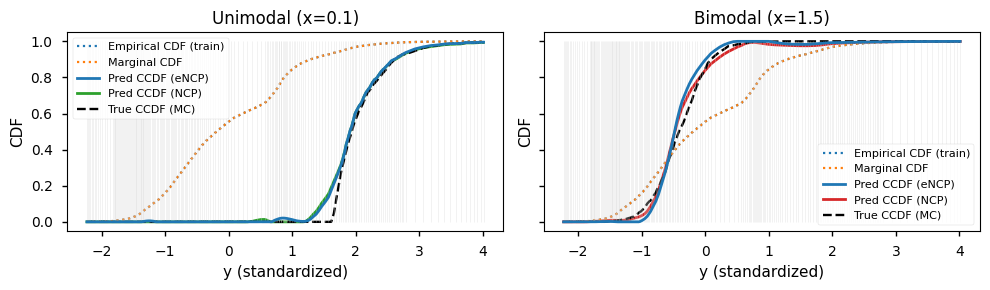

In [10]:
# Choose conditioning values: one unimodal (|x|<=1), one bimodal (1<|x|<=2)
x_vals = torch.tensor([0.1, 1.5], dtype=torch.float32).reshape(-1, 1)  # adjust as desired
labels = ["Unimodal (x=0.1)", "Bimodal (x=1.5)"]
colors = ["tab:green", "tab:red"]
encp_color = "tab:blue"

# Support (standardized y-space) and model marginal CDF on that support
discretized_support = np.asarray(ncp_ccdf.discretized_support).squeeze().ravel()
model_marginal = np.asarray(ncp_ccdf.marginal_CDF).squeeze().ravel()

# Build empirical marginal CDF from training targets (standardized space)
y_all = y_tr_c.squeeze().cpu().numpy()
y_all_sorted = np.sort(y_all)

fig, axs = plt.subplots(1, len(x_vals), figsize=(FIG_SIZE[0] * 2.5, FIG_SIZE[1] * 1), sharey=True)
axs = np.atleast_1d(axs)

for i, (x0, lab, col) in enumerate(zip(x_vals, labels, colors)):
    x0_c = ((x0 - x_mean) / x_std).to(DEVICE)

    ncp_pred = ncp_ccdf(x_cond=x0_c)
    ncp_pred = np.asarray(ncp_pred).squeeze().ravel()

    encp_pred = encp_ccdf(x_cond=x0_c)
    encp_pred = np.asarray(encp_pred).squeeze().ravel()

    # Ground-truth CCDF by sampling via make_dataset at fixed x, then standardize and evaluate at support
    _, y_samp = make_dataset(n=1000, seed=SEED + i, x=float(x0.item()))
    y_samp_c = ((y_samp - y_mean) / y_std).squeeze().cpu().numpy()
    y_samp_sorted = np.sort(y_samp_c)
    gt_cdf = np.searchsorted(y_samp_sorted, discretized_support, side="right") / len(y_samp_sorted)

    plot_conditional_cdf_on_support(
        discretized_support,
        ncp_pred,
        ax=axs[i],
        label_pred="Pred CCDF (NCP)",
        color_pred=col,
        y_train=y_tr_c,  # empirical marginal overlay
        model_marginal_cdf=model_marginal,  # model marginal overlay
        gt_ccdf=gt_cdf,
        label_gt="True CCDF (MC)",
        color_gt="black",
        ls_gt="--",
    )
    plot_conditional_cdf_on_support(
        discretized_support,
        encp_pred,
        ax=axs[i],
        label_pred="Pred CCDF (eNCP)",
        color_pred=encp_color,
        y_train=None,
        model_marginal_cdf=None,
        gt_ccdf=None,
        show_vlines=False,
    )

    handles, legend_labels = axs[i].get_legend_handles_labels()
    order = sorted(range(len(legend_labels)), key=lambda idx: legend_labels[idx].lower())
    axs[i].legend([handles[j] for j in order], [legend_labels[j] for j in order], fontsize=8)

    axs[i].set_title(lab)
    if i == 0:
        axs[i].set_ylabel("CDF")

fig.tight_layout()
fig.savefig(PLOT_PATH / "ccdf_unimodal_bimodal_compare.png", dpi=250)
plt.show()

## Metrics comparison: Baseline vs NCP

In [11]:
# 90% coverage evaluation for NCP on test set (standardized space)
@torch.no_grad()
def coverage_and_size_ncp(ccdf_model, dl, alpha):
    ccdf_model.eval()
    cov = 0.0
    size = 0.0
    n = 0
    for xb, yb in dl:
        q_lo, q_up = ccdf_model.conditional_quantiles(x_cond=xb, alpha=alpha)
        q_lo = torch.as_tensor(q_lo, dtype=torch.float32)
        q_up = torch.as_tensor(q_up, dtype=torch.float32)
        inside = ((q_lo <= yb) & (yb <= q_up)).float().mean()
        seg = (q_up - q_lo).abs().mean()
        cov += inside.item()
        size += seg.item()
        n += 1
    return cov / max(n, 1), size / max(n, 1)


# Collect results for table
import pandas as pd
from IPython.display import Markdown, display

results = []
for alpha in [0.10, 0.20, 0.30, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    cov_ncp, size_ncp = coverage_and_size_ncp(ncp_ccdf, test_dl, alpha)
    cov_encp, size_encp = coverage_and_size_ncp(encp_ccdf, test_dl, alpha)

    results.append(
        {
            "Alpha": alpha,
            "Desired Coverage (%)": (1 - alpha) * 100,
            "NCP Coverage (%)": cov_ncp * 100,
            "eNCP Coverage (%)": cov_encp * 100,
            "NCP CI Size": size_ncp,
            "eNCP CI Size": size_encp,
            "NCP Coverage Error": abs(cov_ncp * 100 - (1 - alpha) * 100),
            "eNCP Coverage Error": abs(cov_encp * 100 - (1 - alpha) * 100),
        }
    )

df_results = pd.DataFrame(results)

float_formats = {
    "Alpha": ".2f",
    "Desired Coverage (%)": ".2f",
    "NCP Coverage (%)": ".2f",
    "eNCP Coverage (%)": ".2f",
    "NCP CI Size": ".3f",
    "eNCP CI Size": ".3f",
    "NCP Coverage Error": ".2f",
    "eNCP Coverage Error": ".2f",
}

comparison_columns = [
    "Alpha",
    "Desired Coverage (%)",
    "NCP Coverage (%)",
    "eNCP Coverage (%)",
    "NCP CI Size",
    "eNCP CI Size",
]
comparison_df = df_results[comparison_columns]

display(Markdown("**Coverage and Confidence Interval Size Results**"))
display(Markdown(dataframe_to_markdown(df_results, index=False, float_formats=float_formats)))

display(Markdown("**Detailed Comparison Table**"))
display(Markdown(dataframe_to_markdown(comparison_df, index=False, float_formats=float_formats)))

**Coverage and Confidence Interval Size Results**

| Alpha | Desired Coverage (%) | NCP Coverage (%) | eNCP Coverage (%) | NCP CI Size | eNCP CI Size | NCP Coverage Error | eNCP Coverage Error |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 0.10 | 90.00 | 91.95 | 88.62 | 1.428 | 1.236 | 1.95 | 1.38 |
| 0.20 | 80.00 | 83.80 | 79.83 | 1.159 | 1.023 | 3.80 | 0.17 |
| 0.30 | 70.00 | 75.30 | 70.37 | 0.986 | 0.876 | 5.30 | 0.37 |
| 0.40 | 60.00 | 64.91 | 60.41 | 0.812 | 0.753 | 4.91 | 0.41 |
| 0.50 | 50.00 | 53.87 | 50.13 | 0.539 | 0.543 | 3.87 | 0.13 |
| 0.60 | 40.00 | 42.43 | 40.66 | 0.381 | 0.349 | 2.43 | 0.66 |
| 0.70 | 30.00 | 30.31 | 30.26 | 0.272 | 0.243 | 0.31 | 0.26 |
| 0.80 | 20.00 | 20.72 | 20.02 | 0.175 | 0.156 | 0.72 | 0.02 |
| 0.90 | 10.00 | 10.43 | 10.21 | 0.087 | 0.077 | 0.43 | 0.21 |

**Detailed Comparison Table**

| Alpha | Desired Coverage (%) | NCP Coverage (%) | eNCP Coverage (%) | NCP CI Size | eNCP CI Size |
| --- | --- | --- | --- | --- | --- |
| 0.10 | 90.00 | 91.95 | 88.62 | 1.428 | 1.236 |
| 0.20 | 80.00 | 83.80 | 79.83 | 1.159 | 1.023 |
| 0.30 | 70.00 | 75.30 | 70.37 | 0.986 | 0.876 |
| 0.40 | 60.00 | 64.91 | 60.41 | 0.812 | 0.753 |
| 0.50 | 50.00 | 53.87 | 50.13 | 0.539 | 0.543 |
| 0.60 | 40.00 | 42.43 | 40.66 | 0.381 | 0.349 |
| 0.70 | 30.00 | 30.31 | 30.26 | 0.272 | 0.243 |
| 0.80 | 20.00 | 20.72 | 20.02 | 0.175 | 0.156 |
| 0.90 | 10.00 | 10.43 | 10.21 | 0.087 | 0.077 |

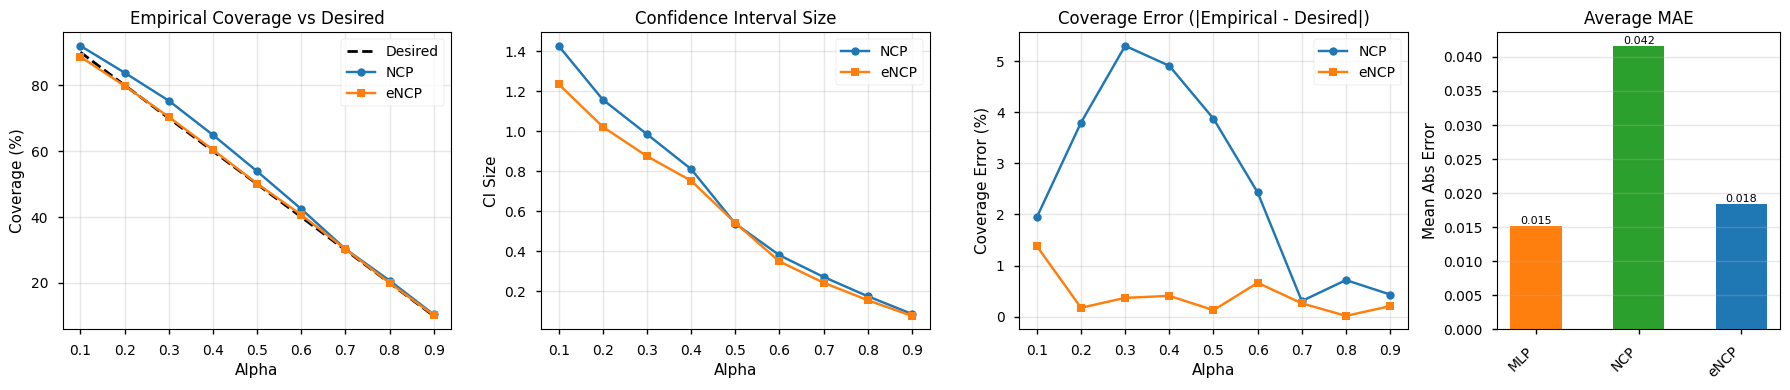

No metrics files found in /home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/plots/metrics matching prefix 'experiment_metrics'.


**Summary Statistics**

| Metric | Value |
| --- | --- |
| Mean Coverage Error - NCP (%) | 2.634 |
| Mean Coverage Error - eNCP (%) | 0.401 |
| Mean CI Size - NCP | 0.649 |
| Mean CI Size - eNCP | 0.584 |
| MAE - MLP | 0.015 |
| MAE - NCP | 0.042 |
| MAE - eNCP | 0.018 |

**Run metrics saved to:** `/home/danfoa/Projects/symm_rep_learn/paper/examples/conditional_expectation_regression/plots/metrics/condexp_metrics_N=20000_seed=42.csv`

In [12]:
# Visualize results in plots
model_colors = {"NCP": "tab:green", "eNCP": "tab:blue", "MLP": "tab:orange"}

# Mean absolute error diagnostics (denormalized space)
y_mean_scalar = float(y_mean.squeeze())
y_std_scalar = float(y_std.squeeze())
y_true = y_true_c.squeeze().cpu().numpy() * y_std_scalar + y_mean_scalar

ce_predictions = {
    "MLP": y_base_c.squeeze().cpu().numpy() * y_std_scalar + y_mean_scalar,
    "NCP": y_pred_ncp_c.squeeze().cpu().numpy() * y_std_scalar + y_mean_scalar,
    "eNCP": y_pred_encp_c.squeeze().cpu().numpy() * y_std_scalar + y_mean_scalar,
}
ce_mae = {name: np.abs(pred - y_true).mean() for name, pred in ce_predictions.items()}
mae_order = ["MLP", "NCP", "eNCP"]
ordered_mae = {name: ce_mae[name] for name in mae_order}

fig, axes = plot_condexp_metrics_panels(
    df_results=df_results,
    mae_by_model=ordered_mae,
    output_path=PLOT_PATH / "coverage_and_size_comparison.png",
    model_colors=model_colors,
    show=True,
)

metrics_dir = PLOT_PATH / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)
run_csv_path, df_run_summary = log_condexp_summary_metrics(
    metrics_dir=metrics_dir,
    sample_size=N,
    seed=SEED,
    df_results=df_results,
    mae_by_model=ce_mae,
)

try:
    fig_eff, ax_eff, agg_eff = plot_sample_efficiency(
        metrics_dir=metrics_dir,
        metric="mae",
        model_order=mae_order,
        model_colors=model_colors,
        output_path=PLOT_PATH / "sample_efficiency.png",
        show=True,
    )
except FileNotFoundError as err:
    print(err)

# Summary statistics (Markdown)
summary_rows = [
    ("Mean Coverage Error - NCP (%)", df_results["NCP Coverage Error"].mean()),
    ("Mean Coverage Error - eNCP (%)", df_results["eNCP Coverage Error"].mean()),
    ("Mean CI Size - NCP", df_results["NCP CI Size"].mean()),
    ("Mean CI Size - eNCP", df_results["eNCP CI Size"].mean()),
]
summary_rows.extend([(f"MAE - {model}", ordered_mae[model]) for model in mae_order])
summary_df = pd.DataFrame(summary_rows, columns=["Metric", "Value"])
summary_formats = {"Value": ".3f"}

display(Markdown("**Summary Statistics**"))
display(Markdown(dataframe_to_markdown(summary_df, index=False, float_formats=summary_formats)))

display(Markdown(f"**Run metrics saved to:** `{run_csv_path}`"))